In [1]:
import pandas as pd
import pulp
from typing import List, Tuple, Dict


In [2]:

import pandas as pd
import pulp
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict

plt.style.use("ggplot")

df = pd.read_csv('Nuclear waste management.csv', index_col=0)

preorder = {
    1: [5],
    2: [1],
    3: [3, 7],
    4: [11],
    5: [14],
    6: [22, 23],
    7: [24],
    8: [27]
}

preferential_info = [(5,1),
                     (1,3),
                     (3,11),
                     (11,14),
                     (14,22),
                     (22,24),
                     (24,27)]

indifference_information = [(3, 7),
                            (22, 23)]

In [3]:

criteria = df.columns.tolist()
alternatives = {x for t in (preferential_info + indifference_information) for x in t}

pulp.LpSolverDefault.msg = 0
problem = pulp.LpProblem("UTA", pulp.LpMaximize)
print("Kryteria:", criteria)

# zmienne dla wartości funkcji użyteczności wariantów z rankingu
u_vars = {}
for alternative in alternatives:
    for criterion in criteria:
        value = df.loc[alternative, criterion]
        criterion_no = criteria.index(criterion) + 1
    
        u_vars[(criterion, value)] = pulp.LpVariable(
            f"u{criterion_no}({value})", lowBound=0, upBound=1
        )

print(u_vars)



Kryteria: ['C1', 'C2', 'C3', 'C4']
{('C1', 0.6): u1(0.6), ('C2', 0.93): u2(0.93), ('C3', 0.0): u3(0.0), ('C4', 0.73): u4(0.73), ('C1', 1.0): u1(1.0), ('C2', 0.45): u2(0.45), ('C3', 0.57): u3(0.57), ('C4', 0.5): u4(0.5), ('C1', 0.62): u1(0.62), ('C2', 0.4): u2(0.4), ('C3', 0.56): u3(0.56), ('C1', 0.4): u1(0.4), ('C2', 0.9): u2(0.9), ('C4', 0.82): u4(0.82), ('C1', 0.61): u1(0.61), ('C2', 0.54): u2(0.54), ('C3', 0.38): u3(0.38), ('C4', 0.49): u4(0.49), ('C1', 0.69): u1(0.69), ('C2', 0.49): u2(0.49), ('C4', 0.61): u4(0.61), ('C1', 0.32): u1(0.32), ('C2', 0.83): u2(0.83), ('C4', 0.94): u4(0.94), ('C1', 0.59): u1(0.59), ('C2', 0.24): u2(0.24), ('C3', 0.7): u3(0.7), ('C4', 0.63): u4(0.63), ('C1', 0.73): u1(0.73), ('C2', 0.03): u2(0.03), ('C3', 1.0): u3(1.0), ('C1', 0.8): u1(0.8), ('C2', 0.06): u2(0.06), ('C4', 0.67): u4(0.67)}


In [4]:
epsilon = pulp.LpVariable("epsilon", lowBound=0)
problem += epsilon

# preporządek
for a, b in preferential_info:
    problem += (
        pulp.lpSum(u_vars[(c, df.loc[a, c])] for c in criteria)
        >= pulp.lpSum(u_vars[(c, df.loc[b, c])] for c in criteria) + epsilon
    )

for a, b in indifference_information:
    problem += pulp.lpSum(u_vars[(c, df.loc[a, c])] for c in criteria) == pulp.lpSum(
        u_vars[(c, df.loc[b, c])] for c in criteria
    )

In [5]:
worst_values = {criterion: df[criterion].max() for criterion in criteria}
best_values = {criterion: df[criterion].min() for criterion in criteria}

breakpoints = {criterion: sorted(df[criterion].unique()) for criterion in criteria}

u_best = []
u_worst = []


for criterion, value in worst_values.items():
    if (criterion, value) not in u_vars:
        criterion_no = criteria.index(criterion) + 1
        u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)

    u_worst.append(u_vars[(criterion, value)])

for criterion, value in best_values.items():
    if (criterion, value) not in u_vars:
        criterion_no = criteria.index(criterion) + 1
        u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)
        
    u_best.append(u_vars[(criterion, value)])


for criterion in breakpoints.keys():
    for value in breakpoints[criterion]:
        if (criterion, value) not in u_vars:
            criterion_no = criteria.index(criterion) + 1
            u_vars[(criterion, value)] = pulp.LpVariable(f"u{criterion_no}({value})", lowBound=0, upBound=1)


problem += pulp.lpSum(u_worst) == 0
problem += pulp.lpSum(u_best) == 1

weights = [1/len(criteria) for _ in criteria]

for criterion in criteria:
    problem += u_vars[(criterion, best_values[criterion])] == 1 * weights[criteria.index(criterion)]

    for i, value in enumerate(breakpoints[criterion]):

        if value == best_values[criterion]:
            continue

        key1 = (criterion, breakpoints[criterion][i])
        key2 = (criterion, breakpoints[criterion][i - 1])

        problem += u_vars[key1] <= u_vars[key2]   

In [6]:
# print(problem)

In [7]:
problem.solve()
print("Status:", pulp.LpStatus[problem.status])
# for v in problem.variables():
#     print(v.name, "=", v.varValue)

Status: Optimal


{'C1': {0.6: 0.25, 1.0: 0.0, 0.62: 0.071428571, 0.4: 0.25, 0.61: 0.071428571, 0.69: 0.0, 0.32: 0.25, 0.59: 0.25, 0.73: 0.0, 0.8: 0.0, 0.34: 0.25, 0.35: 0.25, 0.44: 0.25, 0.45: 0.25, 0.48: 0.25, 0.64: 0.0, 0.65: 0.0, 0.66: 0.0, 0.68: 0.0, 0.71: 0.0, 0.74: 0.0, 0.76: 0.0, 0.78: 0.0, 0.83: 0.0, 0.87: 0.0}, 'C2': {0.93: 0.0, 0.45: 0.10714286, 0.4: 0.10714286, 0.9: 0.0, 0.54: 0.0, 0.49: 0.10714286, 0.83: 0.0, 0.24: 0.10714286, 0.03: 0.25, 0.06: 0.10714286, 1.0: 0.0, 0.22: 0.10714286, 0.25: 0.10714286, 0.27: 0.10714286, 0.3: 0.10714286, 0.44: 0.10714286, 0.55: 0.0, 0.86: 0.0, 0.87: 0.0, 0.91: 0.0, 0.95: 0.0, 0.97: 0.0}, 'C3': {0.0: 0.25, 0.57: 0.25, 0.56: 0.25, 0.38: 0.25, 0.7: 0.0, 1.0: 0.0, 0.45: 0.25, 0.54: 0.25, 0.65: 0.0, 0.71: 0.0, 0.8: 0.0, 0.81: 0.0, 0.88: 0.0}, 'C4': {0.73: 0.14285714, 0.5: 0.25, 0.82: 0.10714286, 0.49: 0.25, 0.61: 0.17857143, 0.94: 0.0, 0.63: 0.14285714, 0.67: 0.14285714, 1.0: 0.0, 0.54: 0.17857143, 0.55: 0.17857143, 0.6: 0.17857143, 0.65: 0.14285714, 0.75: 0.10714

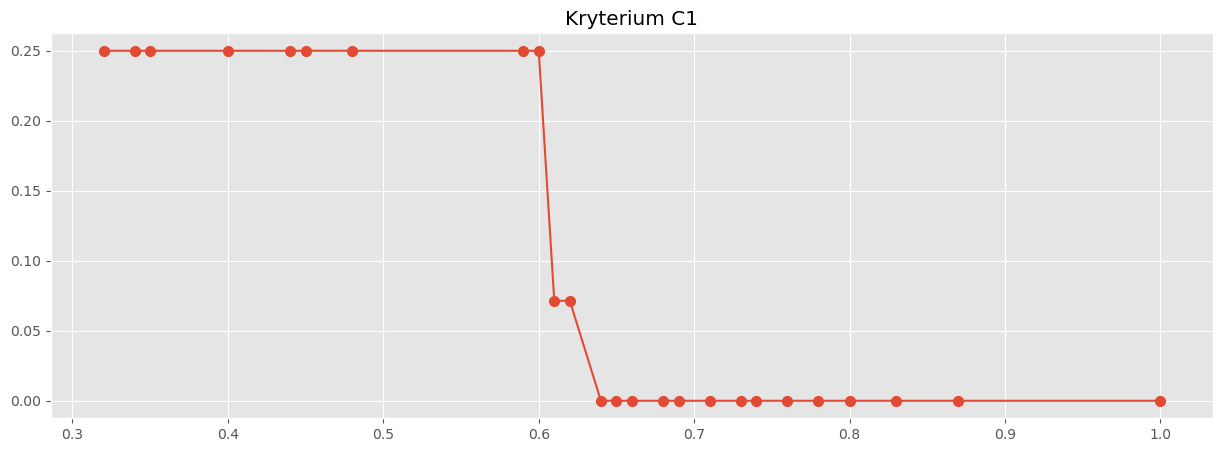

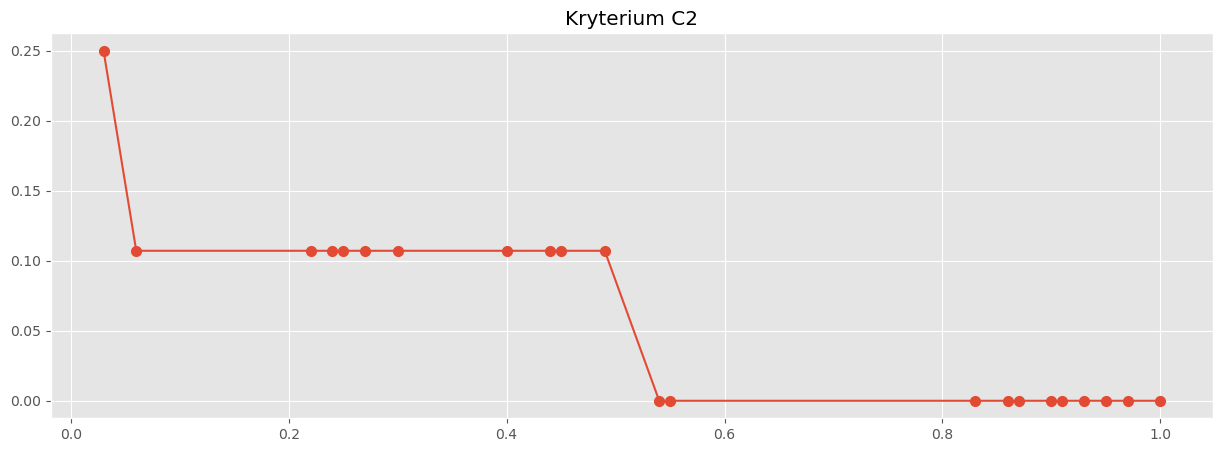

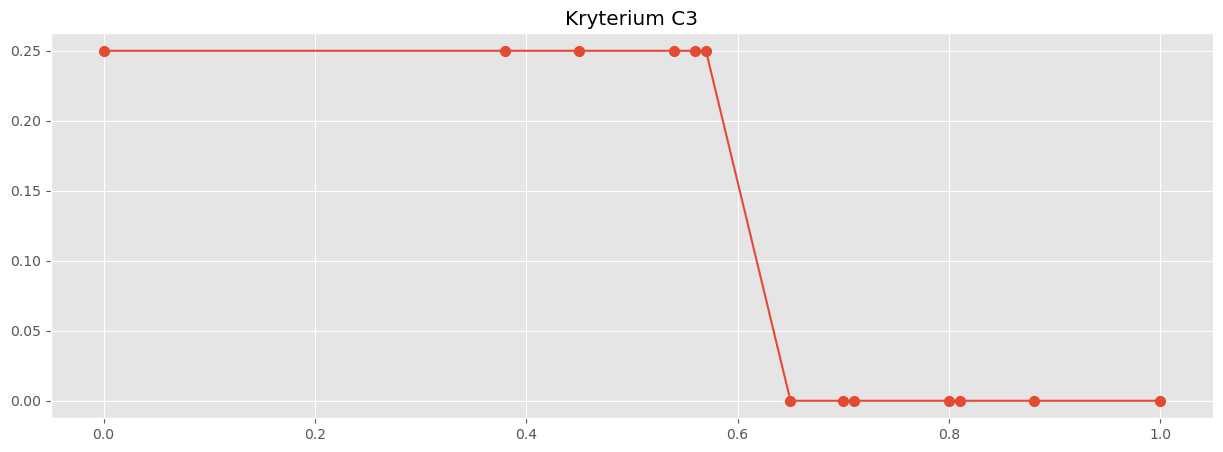

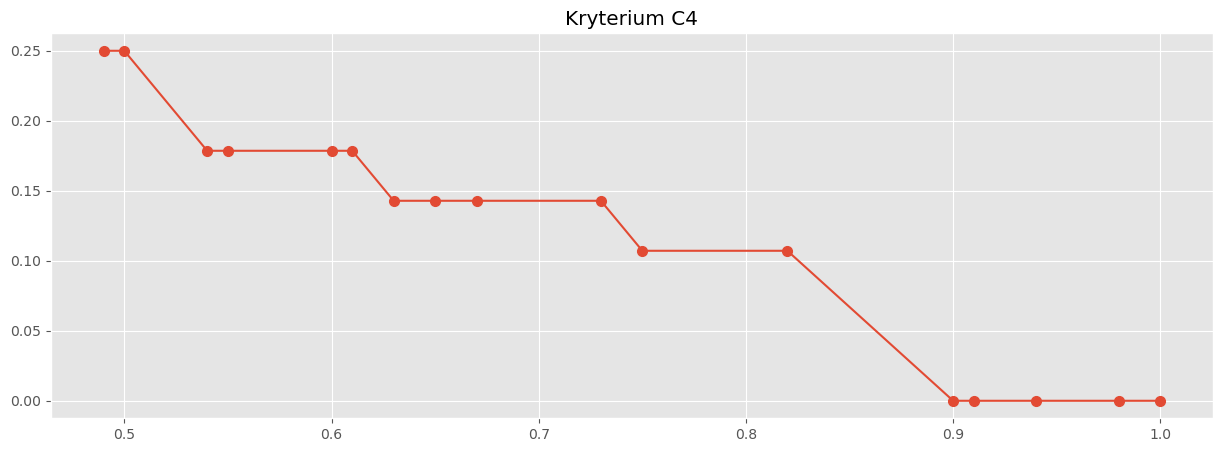

In [8]:
from uta import plot_utility_functions
plot_utility_functions(problem, u_vars, criteria, None)

In [9]:
from uta import create_full_ranking_df

rank = create_full_ranking_df(df, problem, criteria)

In [10]:
rank.sort_values(by=['U'], ascending=False)

,C1,C2,C3,C4,u1,u2,u3,u4,U
5,0.62,0.40,0.56,0.50,0.071429,0.107143,0.25,0.25,0.678571
1,0.60,0.93,0.00,0.73,0.25,0.0,0.25,0.142857,0.642857
10,0.45,0.86,0.00,0.73,0.25,0.0,0.25,0.142857,0.642857
3,1.00,0.45,0.57,0.50,0.0,0.107143,0.25,0.25,0.607143
4,0.48,0.87,0.00,0.75,0.25,0.0,0.25,0.107143,0.607143
7,0.40,0.90,0.00,0.82,0.25,0.0,0.25,0.107143,0.607143
11,0.61,0.54,0.38,0.49,0.071429,0.0,0.25,0.25,0.571429
14,0.69,0.49,0.56,0.61,0.0,0.107143,0.25,0.178571,0.535714
8,0.64,0.44,0.54,0.54,0.0,0.107143,0.25,0.178571,0.535714
22,0.32,0.83,0.00,0.94,0.25,0.0,0.25,0.0,0.5
